# Comparando pipelines

Usando única semilla

> lgbm prepro6 fe6 y 12 opt (local opt 10 % de CONTINUA)

> lgbm prepro6 fe6 y 12 opt (cloud opt 10 % de CONTINUA)

> lgbm semillerio de Denicolay

In [1]:
!pip install dask[dataframe]
!pip install tabulate

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.

[notice] A new release of pip is available: 24.3 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Librerias
import os
import pandas as pd
import numpy as np

#######
# rutas
# datasets
from config import dataset_file_fe6_6xpqt
# optimizacion
from config import db_path
# modelos
from config import modelos_path
# predicciones
from config import pred_path

##########
# pipeline
from processing import ModelPipeline, plot_comparisons_on_kaggle_split
from processing import analyze_study
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import optuna
import warnings

# Ignorar advertencias de tipo UserWarning
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
warnings.filterwarnings('ignore', category=Warning, module='lightgbm')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

Matplotlib is building the font cache; this may take a moment.
/home/santtedo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Variables de train y test

In [3]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_3_meses = [202105, 202106, 202107]

mes_train_ult_6_meses = [202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_9_meses = [202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_anio = [202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train = [202107]
mes_test = 202109

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

## Modelos candidatos

### 10 meses de back-testing

> lgbm prepro6 fe6 y 12 opt (local opt 10 % de CONTINUA)

> xgb prepro6 fe6 comp02

### normalizando variables de montos y transacciones

> Mismos modelos

Normalizando variables del train que empiecen con:

In [4]:
# to_norm = [col for col in X_train.columns if col.startswith(('m', 'Visa_m', 'Master_m', 'vm_m', 'ctrx_quarter'))]

### train_all quitando meses rotos

> Mismos modelos

sin pandemia conflictiva [202004, 202005, 202006, 202007]

y sin rotos en 2019 [201905, 201910]

Quedando:

In [5]:
# mes_bt_train_all = [201901, 201902, 201903, 201904, 201906, 201907, 
#                  201908, 201909, 201911, 201912, 202001, 202002, 
#                  202003, 202008, 202009, 202010, 202011, 202012,
#                  202101, 202102, 202103, 202104, 202105]

## Loading data

Solo ejecutable en la nube

In [21]:
data = pd.read_parquet(dataset_file_fe6_6xpqt)

# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

# Simulación para Kaggle
mes_bt_ult_anio = [202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105]

X_train = data[data['foto_mes'].isin(mes_bt_ult_anio)]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202107 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

# del data

## 10 meses de back-testing


Preprocesando data

In [22]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

Columns with all NaN values: ['payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


### lightgbm prepro6 fe6 y 12 opt (local opt under) 

**Prepro in 6 months Conceptual FE 6 months + Lag1 + Delta1**

comp03_prepro_6x.ipynb

comp03_fe6_6x.ipynb

**Usando los últimos 12 meses para optimizar** con 10 % de CONTINUA

comp03_pipeline_optx.ipynb

### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.691198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86266
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 664
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from score -5.347249

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 127967000.0 por mes
Según un promedio de los 1 meses evaluados

# Optimizando el modelo


[I 2024-12-02 14:51:39,968] Using an existing study with name 'exp_lgbm_comp03_local_v00' instead of creating a new one.


Mejores parámetros para lightgbm: {'n_estimators': 586, 'num_leaves': 72, 'learning_rate': 0.03225820947502308, 'min_data_in_leaf': 182, 'feature_fraction': 0.5612204369575097}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] feature_fraction is set=0.5612204369575097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612204369575097
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] feature_fraction is set=0.5612204369575097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612204369575097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.546855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

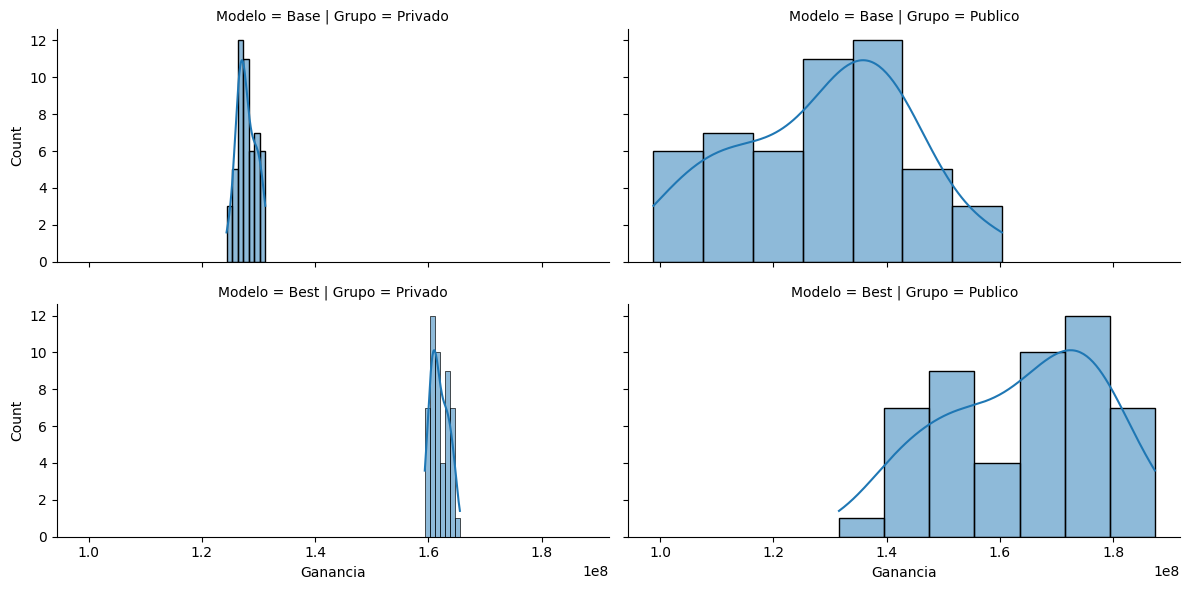

Ganancia media del modelo base en privado: 127881755.55555555
Ganancia media del modelo base en público: 128734200.0
Ganancia media del modelo Best en privado: 161982644.44444442
Ganancia media del modelo Best en público: 163916200.0


In [8]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_opt = ModelPipeline(data=None, seeds=semillas,
                                        model_type='lightgbm', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_opt.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_opt.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_name = "sqlite:///" + db_path + "optimization_tree.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_lgbm_comp03_local_v00"

print("\n# Optimizando el modelo")
pipeline_lgbm_opt.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_opt.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_opt.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_opt, fpri_base_lgbm_opt, \
fpub_best_lgbm_opt, fpub_base_lgbm_opt = \
pipeline_lgbm_opt.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1) # sin imputer ni to_drop porque estan prepro

Guardo resultados best para generar un registro reutilizable

In [9]:
df_bt = pd.DataFrame({
    'pri_best_opt': fpri_best_lgbm_opt,
    'pub_best_opt': fpub_best_lgbm_opt,
})

# df_bt = pd.read_csv(db_path+'pipeline_comp_bt.csv')

# df_bt['pri_best_opt'] = fpri_best_lgbm_opt
# df_bt['pub_best_opt'] = fpub_best_lgbm_opt

### xgb prepro6 fe6 comp02 

**Prepro in 6 months Conceptual FE 6 months + Lag1 + Delta1**

comp03_prepro_6x.ipynb

comp03_fe6_6x.ipynb

### Corriendo pipeline con XGBoost ###

# Entrenando el modelo base LightGBM

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 153321000.0 por mes
Según un promedio de los 1 meses evaluados

# Entrenando el mejor modelo con parámetros optimizados

# Evaluando el mejor modelo en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 164969000.0 por mes
Según un promedio de los 1 meses evaluados

# Simulando el split Kaggle y comparando modelos


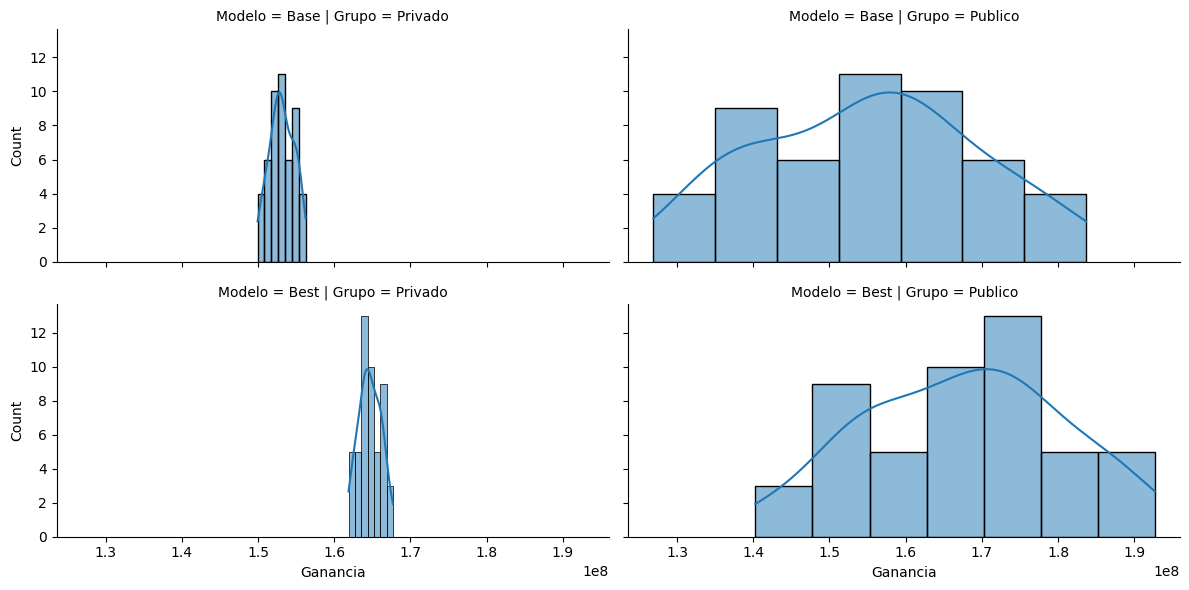

Ganancia media del modelo base en privado: 153138066.66666666
Ganancia media del modelo base en público: 154967400.0
Ganancia media del modelo Best en privado: 164688066.6666667
Ganancia media del modelo Best en público: 167497400.0


In [10]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con XGBoost ###")
# Inicializar el pipeline con 'xgboost'
pipeline_xgb_02 = ModelPipeline(data=None, seeds=semillas,
                                        model_type='xgboost', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_xgb_02.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_xgb_02.test_base_model(X_test_imp, y_test)

# Mejor modelo de la comp02
pipeline_xgb_02.best_params = {'n_estimators': 464, 
                            'max_leaves': 228, 
                            'eta': 0.026841741174110256, 
                            'gamma': 0.6065611085207565, 
                            'min_child_weight': 10, 
                            'subsample': 0.8649413237261332, 
                            'colsample_bytree': 0.5013152719066779}

pipeline_xgb_02.best_params.update({'n_jobs': -1})

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_xgb_02.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_xgb_02.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_xgb_02, fpri_base_xgb_02, \
fpub_best_xgb_02, fpub_base_xgb_02 = \
pipeline_xgb_02.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1) # sin imputer ni to_drop porque estan prepro

In [11]:
df_bt['pri_best_xgb_02'] = fpri_best_xgb_02
df_bt['pub_best_xgb_02'] = fpub_best_xgb_02

## Normalizando variables de montos y transacciones

In [23]:
from sklearn.preprocessing import StandardScaler

starting_to_norm = (
    'm', 'Visa_m', 'Master_m', 'vm_m', 'ctrx_quarter',
    'lag_1_m', 'lag_2_m', 'delta_1_m', 'delta_2_m',
    'lag_1_Visa_m', 'lag_2_Visa_m', 'delta_1_Visa_m', 'delta_2_Visa_m',
    'lag_1_Master_m', 'lag_2_Master_m', 'delta_1_Master_m', 'delta_2_Master_m',
    'lag_1_vm_m', 'lag_2_vm_m', 'delta_1_vm_m', 'delta_2_vm_m',
    'lag_1_ctrx_quarter', 'lag_2_ctrx_quarter', 'delta_1_ctrx_quarter', 'delta_2_ctrx_quarter'
)

to_norm = [col for col in X_train_imp.columns if col.startswith(starting_to_norm)]

scaler = StandardScaler()

X_train_imp[to_norm] = scaler.fit_transform(X_train_imp[to_norm])
X_test_imp[to_norm] = scaler.transform(X_test_imp[to_norm])

### lightgbm prepro6 fe6 y 12 opt (local opt under) 


### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.408288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85699
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 664
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from score -5.347249

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 125265000.0 por mes
Según un promedio de los 1 meses evaluados

# Optimizando el modelo


[I 2024-12-02 16:27:22,146] Using an existing study with name 'exp_lgbm_comp03_local_v00' instead of creating a new one.


Mejores parámetros para lightgbm: {'n_estimators': 586, 'num_leaves': 72, 'learning_rate': 0.03225820947502308, 'min_data_in_leaf': 182, 'feature_fraction': 0.5612204369575097}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] feature_fraction is set=0.5612204369575097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612204369575097
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] feature_fraction is set=0.5612204369575097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612204369575097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.528590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

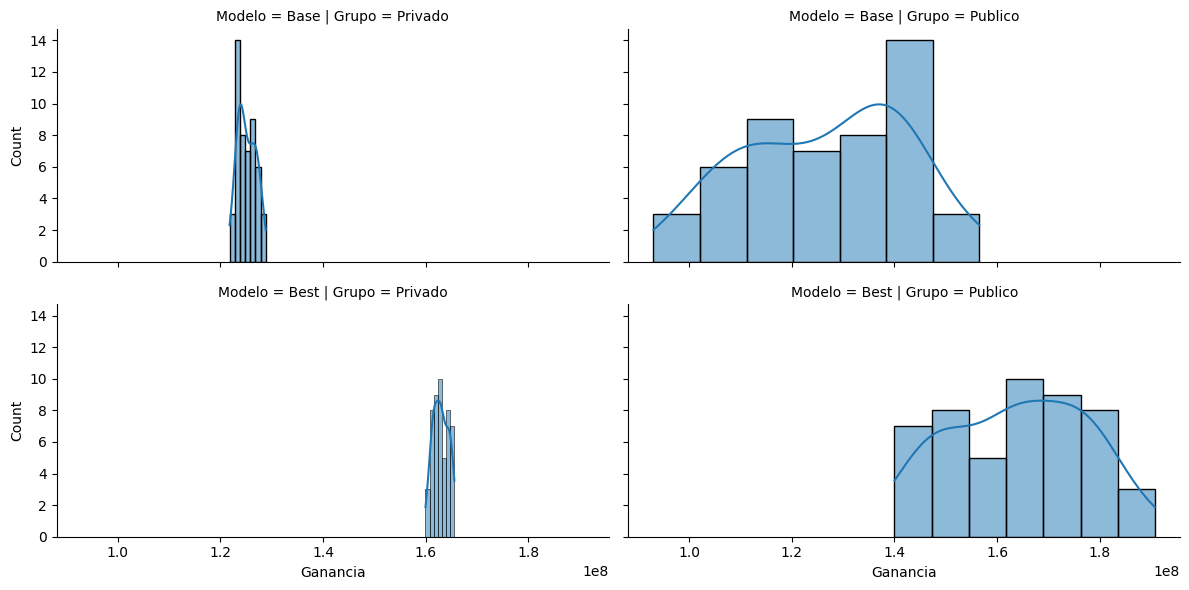

Ganancia media del modelo base en privado: 125131066.66666666
Ganancia media del modelo base en público: 126470400.0
Ganancia media del modelo Best en privado: 162943822.22222224
Ganancia media del modelo Best en público: 163945600.0


In [24]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_opt_norm = ModelPipeline(data=None, seeds=semillas,
                                        model_type='lightgbm', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_opt_norm.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_opt_norm.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_name = "sqlite:///" + db_path + "optimization_tree.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_lgbm_comp03_local_v00"

print("\n# Optimizando el modelo")
pipeline_lgbm_opt_norm.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_opt_norm.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_opt_norm.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_opt_norm, fpri_base_lgbm_opt_norm, \
fpub_best_lgbm_opt_norm, fpub_base_lgbm_opt_norm = \
pipeline_lgbm_opt_norm.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1) 

In [25]:
df_bt['pri_best_opt_norm'] = fpri_best_lgbm_opt_norm
df_bt['pub_best_opt_norm'] = fpub_best_lgbm_opt_norm

### xgb prepro6 fe6 comp02 

### Corriendo pipeline con XGBoost ###

# Entrenando el modelo base LightGBM

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 158935000.0 por mes
Según un promedio de los 1 meses evaluados

# Entrenando el mejor modelo con parámetros optimizados

# Evaluando el mejor modelo en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 165172000.0 por mes
Según un promedio de los 1 meses evaluados

# Simulando el split Kaggle y comparando modelos


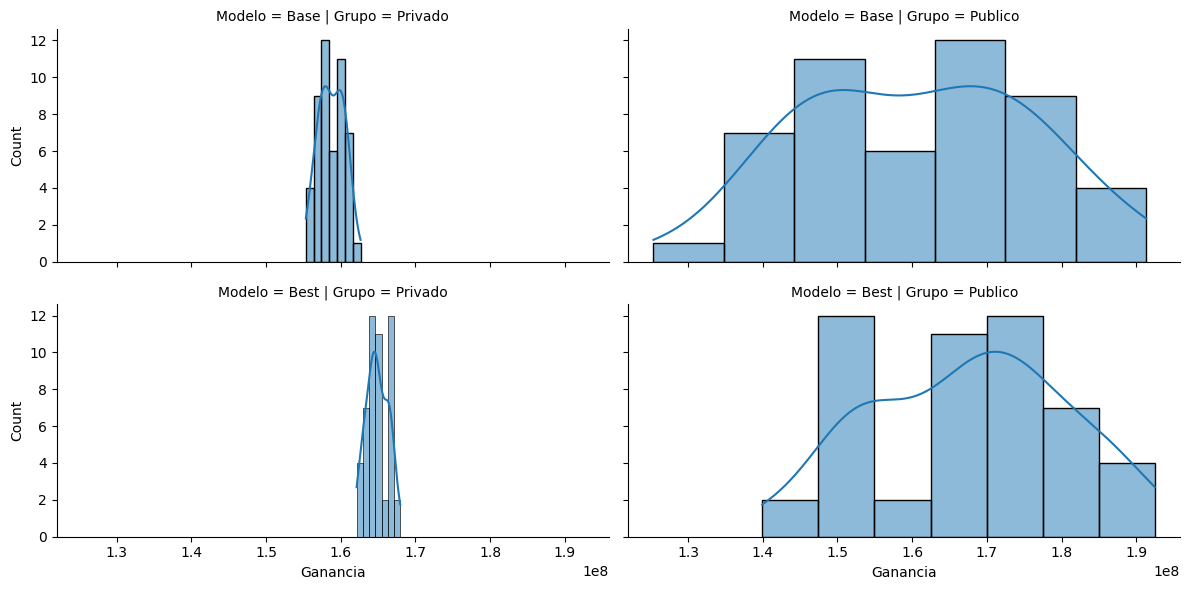

Ganancia media del modelo base en privado: 158779755.55555555
Ganancia media del modelo base en público: 160332200.0
Ganancia media del modelo Best en privado: 164909266.66666663
Ganancia media del modelo Best en público: 167536600.0


In [26]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_ult_anio)

print("### Corriendo pipeline con XGBoost ###")
# Inicializar el pipeline con 'xgboost'
pipeline_xgb_02_norm = ModelPipeline(data=None, seeds=semillas,
                                        model_type='xgboost', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_xgb_02_norm.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_xgb_02_norm.test_base_model(X_test_imp, y_test)

# Mejor modelo de la comp02
pipeline_xgb_02_norm.best_params = {'n_estimators': 464, 
                            'max_leaves': 228, 
                            'eta': 0.026841741174110256, 
                            'gamma': 0.6065611085207565, 
                            'min_child_weight': 10, 
                            'subsample': 0.8649413237261332, 
                            'colsample_bytree': 0.5013152719066779}

pipeline_xgb_02_norm.best_params.update({'n_jobs': -1})

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_xgb_02_norm.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_xgb_02_norm.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_xgb_02_norm, fpri_base_xgb_02_norm, \
fpub_best_xgb_02_norm, fpub_base_xgb_02_norm = \
pipeline_xgb_02_norm.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1)

In [27]:
df_bt['pri_best_xgb_02_norm'] = fpri_best_xgb_02_norm
df_bt['pub_best_xgb_02_norm'] = fpub_best_xgb_02_norm

## train_all quitando meses rotos

sin normalizar


In [28]:
del X_train_imp
del X_test_imp

mes_bt_train_all = [
                    # 201901, 201902, 201903, 201904, 201906, 201907, # no los agregó por rotura de variables creadas
                    201908, 201909, 201911, 201912, 202001, 202002, 
                    202003, 202008, 202009, 202010, 202011, 202012,
                    202101, 202102, 202103, 202104, 202105
                    ] # igualmente habra variables perturbadas en los meses que no son tenidos en cuenta

X_train = data[data['foto_mes'].isin(mes_bt_train_all)]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202107 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

del data

Preprocesando data

In [29]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

Columns with all NaN values: ['payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


### lightgbm prepro6 fe6 y 12 opt (local opt under) 


### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.085538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87336
[LightGBM] [Info] Number of data points in the train set: 2601235, number of used features: 665
[LightGBM] [Info] Start training from score -0.008663
[LightGBM] [Info] Start training from score -5.445598
[LightGBM] [Info] Start training from score -5.446668

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 154861000.0 por mes
Según un promedio de los 1 meses evaluados

# Optimizando el modelo


[I 2024-12-02 17:05:37,236] Using an existing study with name 'exp_lgbm_comp03_local_v00' instead of creating a new one.


Mejores parámetros para lightgbm: {'n_estimators': 586, 'num_leaves': 72, 'learning_rate': 0.03225820947502308, 'min_data_in_leaf': 182, 'feature_fraction': 0.5612204369575097}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] feature_fraction is set=0.5612204369575097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612204369575097
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] feature_fraction is set=0.5612204369575097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5612204369575097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.925731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

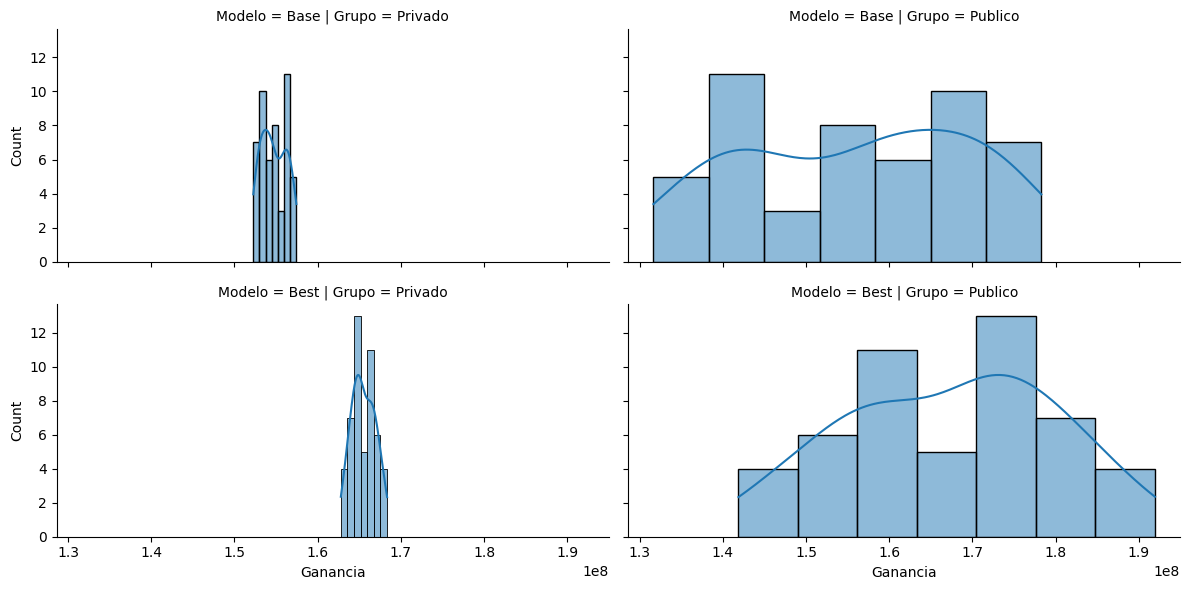

Ganancia media del modelo base en privado: 154741066.6666667
Ganancia media del modelo base en público: 155940400.0
Ganancia media del modelo Best en privado: 165504733.3333333
Ganancia media del modelo Best en público: 167427400.0


In [30]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_train_all)

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_opt_all = ModelPipeline(data=None, seeds=semillas,
                                        model_type='lightgbm', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_opt_all.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_opt_all.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_name = "sqlite:///" + db_path + "optimization_tree.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_lgbm_comp03_local_v00"

print("\n# Optimizando el modelo")
pipeline_lgbm_opt_all.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_opt_all.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_opt_all.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_opt_all, fpri_base_lgbm_opt_all, \
fpub_best_lgbm_opt_all, fpub_base_lgbm_opt_all = \
pipeline_lgbm_opt_all.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1)

In [31]:
df_bt['pri_best_opt_all'] = fpri_best_lgbm_opt_all
df_bt['pub_best_opt_all'] = fpub_best_lgbm_opt_all

### xgb prepro6 fe6 comp02 

sin normalizar

### Corriendo pipeline con XGBoost ###

# Entrenando el modelo base LightGBM

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 160629000.0 por mes
Según un promedio de los 1 meses evaluados

# Entrenando el mejor modelo con parámetros optimizados

# Evaluando el mejor modelo en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 163884000.0 por mes
Según un promedio de los 1 meses evaluados

# Simulando el split Kaggle y comparando modelos


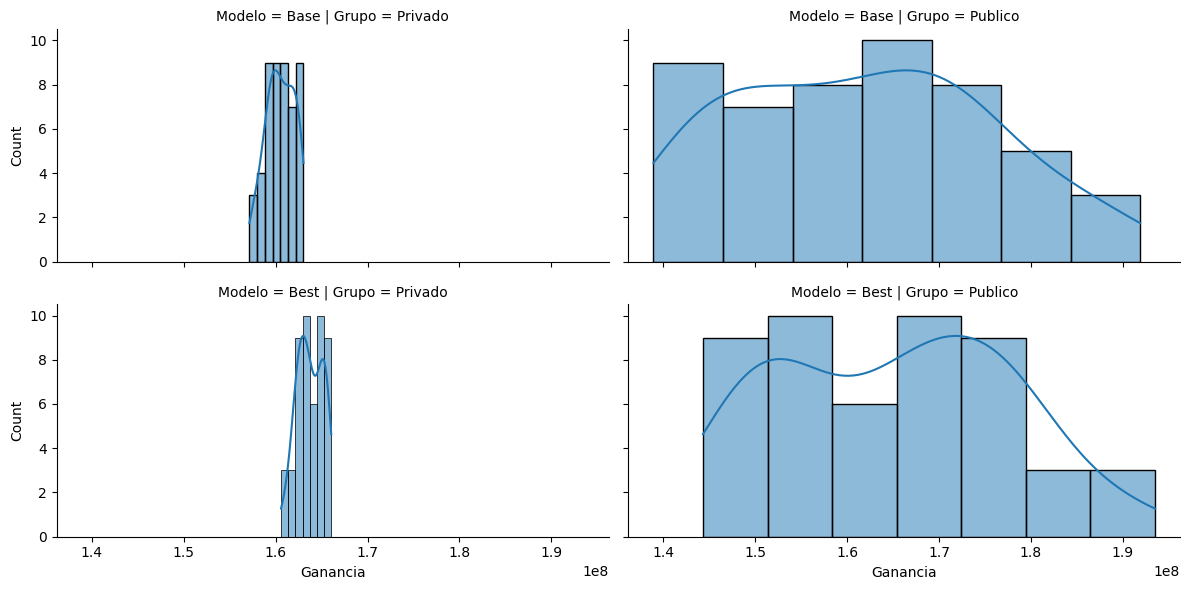

Ganancia media del modelo base en privado: 160518088.8888889
Ganancia media del modelo base en público: 161627200.0
Ganancia media del modelo Best en privado: 163742288.88888887
Ganancia media del modelo Best en público: 165159400.0


In [32]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = len(mes_bt_train_all)

print("### Corriendo pipeline con XGBoost ###")
# Inicializar el pipeline con 'xgboost'
pipeline_xgb_02_all = ModelPipeline(data=None, seeds=semillas,
                                        model_type='xgboost', seed=s, 
                                        meses_opt=training, meses_test=1,
                                        threshold=0.015, # según optx 
                                        n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_xgb_02_all.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_xgb_02_all.test_base_model(X_test_imp, y_test)

# Mejor modelo de la comp02
pipeline_xgb_02_all.best_params = {'n_estimators': 464, 
                            'max_leaves': 228, 
                            'eta': 0.026841741174110256, 
                            'gamma': 0.6065611085207565, 
                            'min_child_weight': 10, 
                            'subsample': 0.8649413237261332, 
                            'colsample_bytree': 0.5013152719066779}

pipeline_xgb_02_all.best_params.update({'n_jobs': -1})

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_xgb_02_all.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_xgb_02_all.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_xgb_02_all, fpri_base_xgb_02_all, \
fpub_best_xgb_02_all, fpub_base_xgb_02_all = \
pipeline_xgb_02_all.simulate_kaggle_split(X_test_imp, y_test, test_size=0.1)

In [33]:
df_bt['pri_best_xgb_02_all'] = fpri_best_xgb_02_all
df_bt['pub_best_xgb_02_all'] = fpub_best_xgb_02_all

## Elección del modelo optimizado

Distintos pipelines en sus pruebas de backtesting

In [34]:
df_bt.to_csv(db_path+'pipeline_comp_bt_lastdance.csv')

df_bt.head()

,pri_best_opt,pub_best_opt,pri_best_xgb_02,pub_best_xgb_02,pri_best_opt_norm,pub_best_opt_norm,pri_best_xgb_02_norm,pub_best_xgb_02_norm,pri_best_opt_all,pub_best_opt_all,pri_best_xgb_02_all,pub_best_xgb_02_all
0,1.617778e+08,165760000.0,1.653322e+08,161700000.0,1.631233e+08,162330000.0,1.649433e+08,167230000.0,1.660867e+08,162190000.0,1.638856e+08,163870000.0
1,1.601600e+08,180320000.0,1.638389e+08,175140000.0,1.610467e+08,181020000.0,1.641111e+08,174720000.0,1.648811e+08,173040000.0,1.621978e+08,179060000.0
2,1.643056e+08,143010000.0,1.659389e+08,156240000.0,1.650444e+08,145040000.0,1.655967e+08,161350000.0,1.663822e+08,159530000.0,1.646556e+08,156940000.0
3,1.618556e+08,165060000.0,1.658300e+08,157220000.0,1.631700e+08,161910000.0,1.665300e+08,152950000.0,1.664833e+08,158620000.0,1.657133e+08,147420000.0
4,1.632944e+08,152110000.0,1.647489e+08,166950000.0,1.642589e+08,152110000.0,1.649978e+08,166740000.0,1.652700e+08,169540000.0,1.649822e+08,154000000.0


Comparando modelos: lgbm opt vs. xgb 02


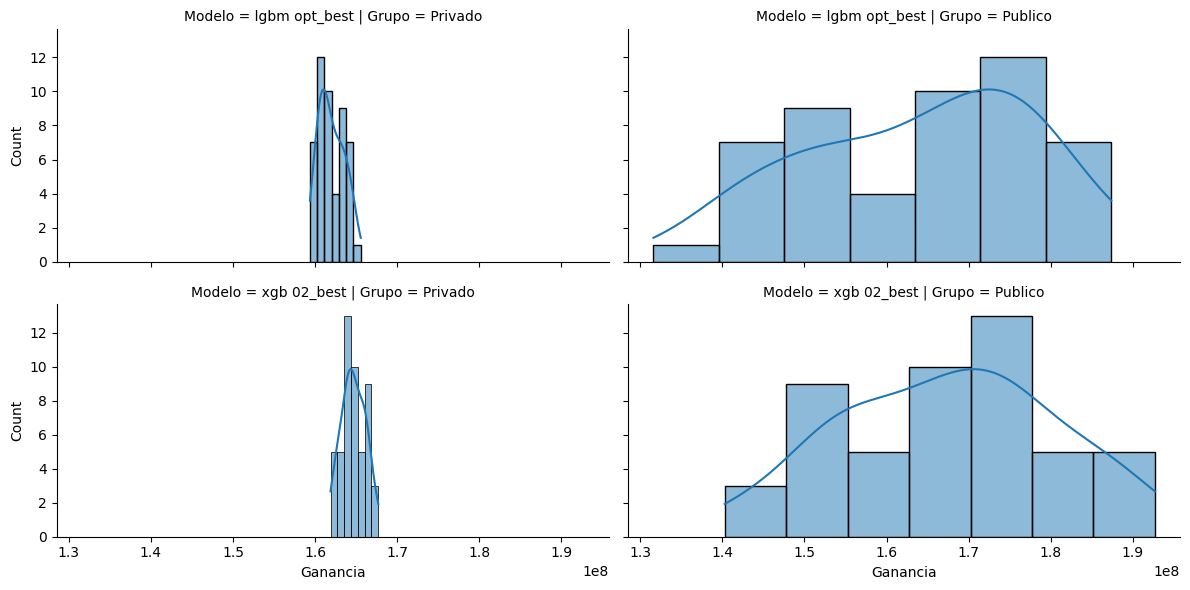

Ganancia media del modelo lgbm opt privado: 161982644.44444442
Ganancia media del modelo lgbm opt publico: 163916200.0
Ganancia media del modelo xgb 02 privado: 164688066.6666667
Ganancia media del modelo xgb 02 publico: 167497400.0

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 288.0
P-valor = 1.6943507636062633e-11
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb 02_priv es mayor que la de lgbm opt_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1098.5
P-valor = 0.148937505342983
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb 02_pub es mayor que la de lgbm opt_pub.


In [35]:
model_a = "lgbm opt"
model_b = "xgb 02"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_opt.values, df_bt.pub_best_opt.values,
                                model_b, df_bt.pri_best_xgb_02.values, df_bt.pub_best_xgb_02.values)

Comparando modelos: lgbm opt norm vs. xgb 02 norm


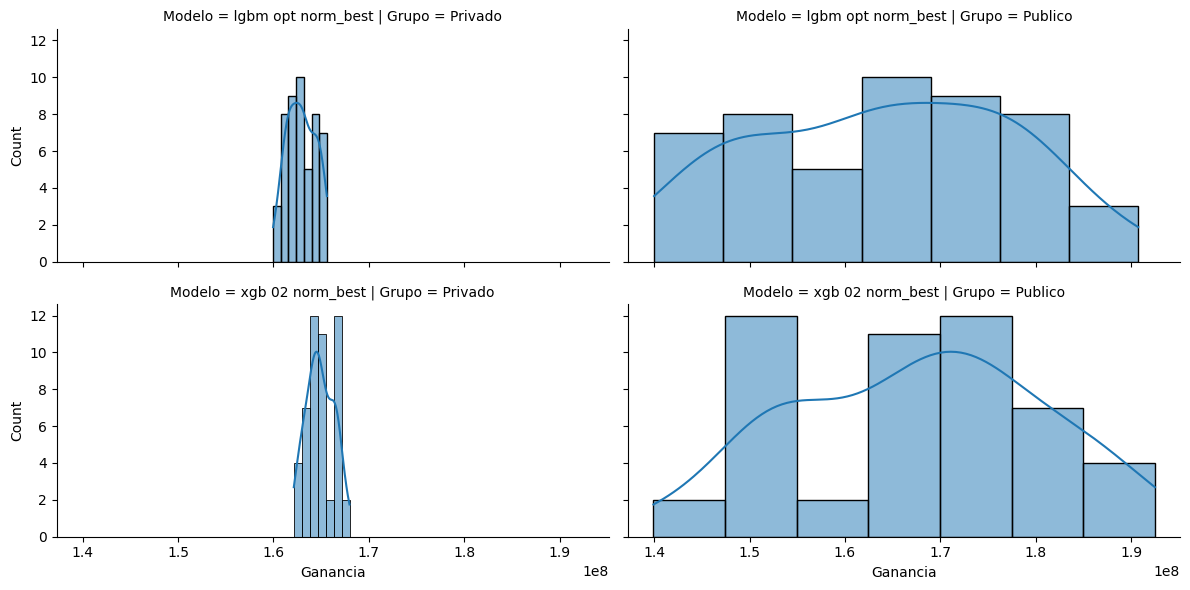

Ganancia media del modelo lgbm opt norm privado: 162943822.22222224
Ganancia media del modelo lgbm opt norm publico: 163945600.0
Ganancia media del modelo xgb 02 norm privado: 164909266.66666663
Ganancia media del modelo xgb 02 norm publico: 167536600.0

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 470.0
P-valor = 3.8561604118496367e-08
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb 02 norm_priv es mayor que la de lgbm opt norm_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1059.0
P-valor = 0.0945428849314075
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb 02 norm_pub es mayor que la de lgbm opt norm_pub.


In [36]:
model_a = "lgbm opt norm"
model_b = "xgb 02 norm"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_opt_norm.values, df_bt.pub_best_opt_norm.values,
                                model_b, df_bt.pri_best_xgb_02_norm.values, df_bt.pub_best_xgb_02_norm.values)

Comparando modelos: lgbm opt vs. lgbm opt norm


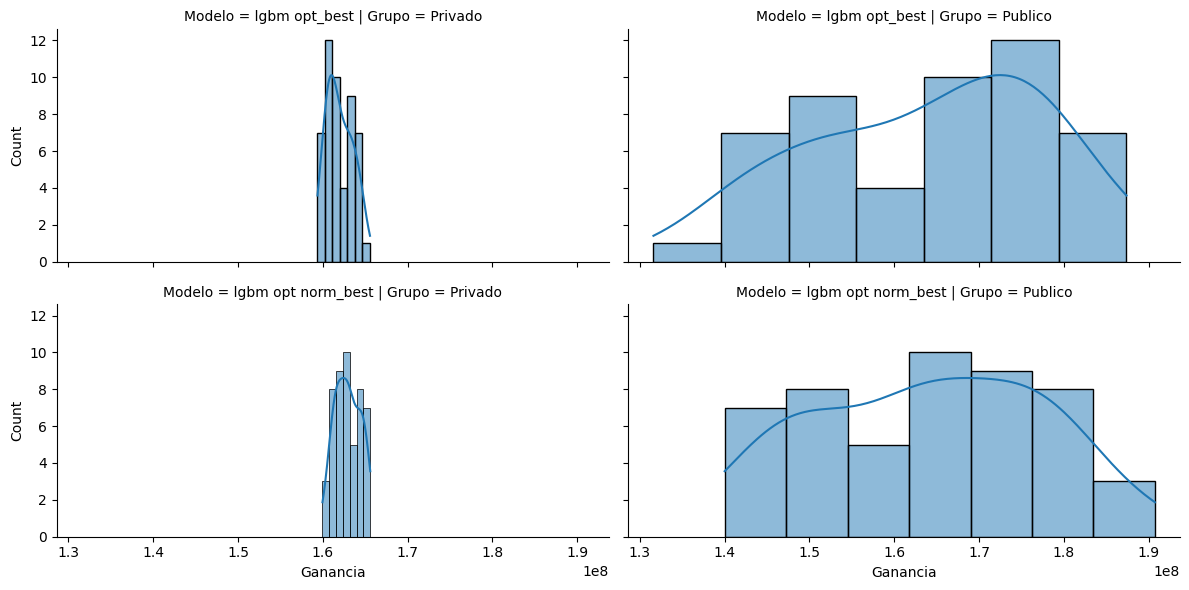

Ganancia media del modelo lgbm opt privado: 161982644.44444442
Ganancia media del modelo lgbm opt publico: 163916200.0
Ganancia media del modelo lgbm opt norm privado: 162943822.22222224
Ganancia media del modelo lgbm opt norm publico: 163945600.0

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 821.5
P-valor = 0.0015857456039728543
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de lgbm opt norm_priv es mayor que la de lgbm opt_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1261.5
P-valor = 0.5329656251623078
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de lgbm opt norm_pub es mayor que la de lgbm opt_pub.


In [37]:
model_a = "lgbm opt"
model_b = "lgbm opt norm"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_opt.values, df_bt.pub_best_opt.values,
                                model_b, df_bt.pri_best_opt_norm.values, df_bt.pub_best_opt_norm.values)

Comparando modelos: xgb 02 norm vs. lgbm opt norm


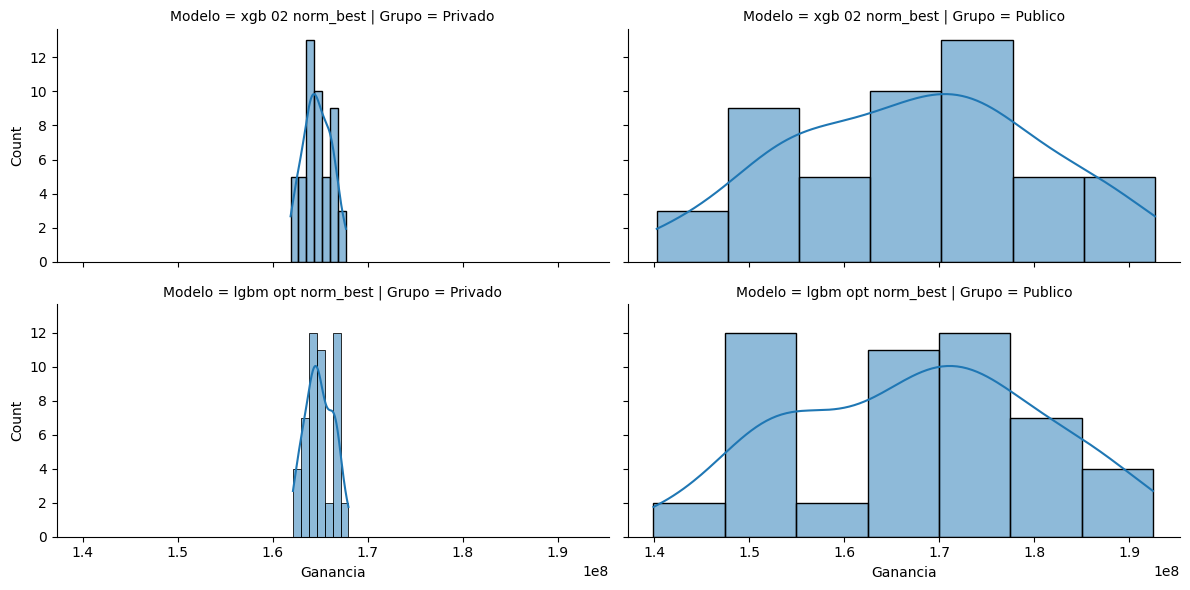

Ganancia media del modelo xgb 02 norm privado: 164688066.6666667
Ganancia media del modelo xgb 02 norm publico: 167497400.0
Ganancia media del modelo lgbm opt norm privado: 164909266.66666663
Ganancia media del modelo lgbm opt norm publico: 167536600.0

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1123.5
P-valor = 0.19252287106179883
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de lgbm opt norm_priv es mayor que la de xgb 02 norm_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1268.5
P-valor = 0.5521066987195012
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de lgbm opt norm_pub es mayor que la de xgb 02 norm_pub.


In [38]:
model_a = "xgb 02"
model_a = "xgb 02 norm"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_xgb_02.values, df_bt.pub_best_xgb_02.values,
                                model_b, df_bt.pri_best_xgb_02_norm.values, df_bt.pub_best_xgb_02_norm.values)

Comparando modelos: lgbm opt all vs. xgb 02 all


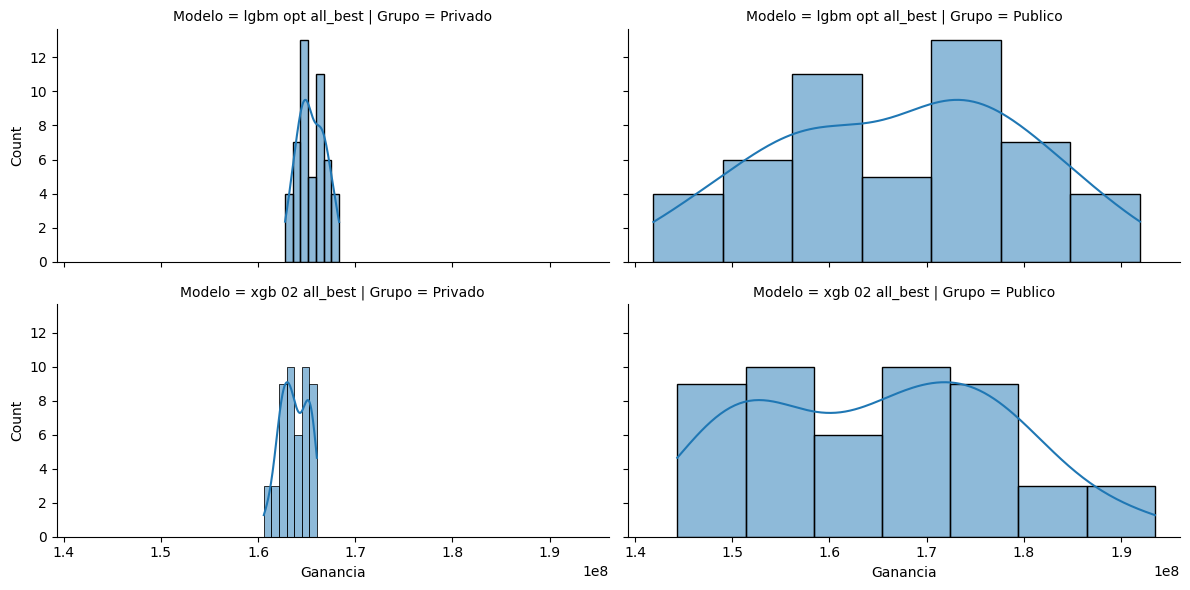

Ganancia media del modelo lgbm opt all privado: 165504733.3333333
Ganancia media del modelo lgbm opt all publico: 167427400.0
Ganancia media del modelo xgb 02 all privado: 163742288.88888887
Ganancia media del modelo xgb 02 all publico: 165159400.0

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1992.0
P-valor = 0.9999998461690154
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgb 02 all_priv es mayor que la de lgbm opt all_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1380.5
P-valor = 0.8167631985817623
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgb 02 all_pub es mayor que la de lgbm opt all_pub.


In [39]:
model_a = "lgbm opt all"
model_b = "xgb 02 all"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_opt_all.values, df_bt.pub_best_opt_all.values,
                                model_b, df_bt.pri_best_xgb_02_all.values, df_bt.pub_best_xgb_02_all.values)

Comparando modelos: lgbm opt vs. lgbm opt all


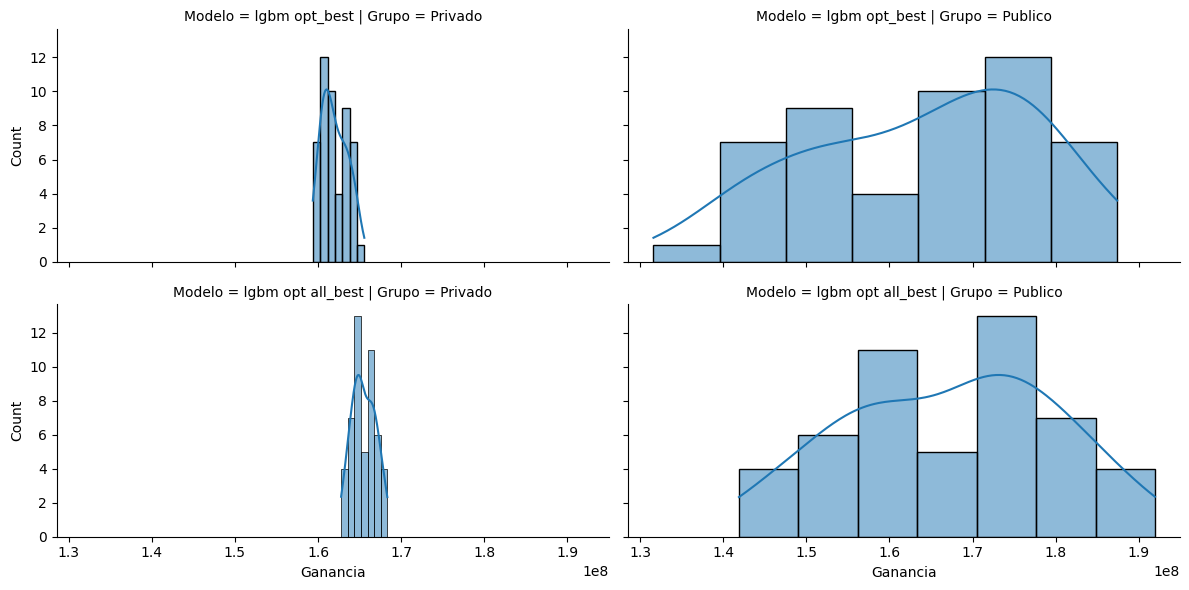

Ganancia media del modelo lgbm opt privado: 161982644.44444442
Ganancia media del modelo lgbm opt publico: 163916200.0
Ganancia media del modelo lgbm opt all privado: 165504733.3333333
Ganancia media del modelo lgbm opt all publico: 167427400.0

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 126.0
P-valor = 4.770454195531095e-15
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de lgbm opt all_priv es mayor que la de lgbm opt_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1087.0
P-valor = 0.1313023829680927
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de lgbm opt all_pub es mayor que la de lgbm opt_pub.


In [40]:
model_a = "lgbm opt"
model_b = "lgbm opt all"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_opt.values, df_bt.pub_best_opt.values,
                                model_b, df_bt.pri_best_opt_all.values, df_bt.pub_best_opt_all.values)

Comparando modelos: xgb 02 vs. xgb 02 all


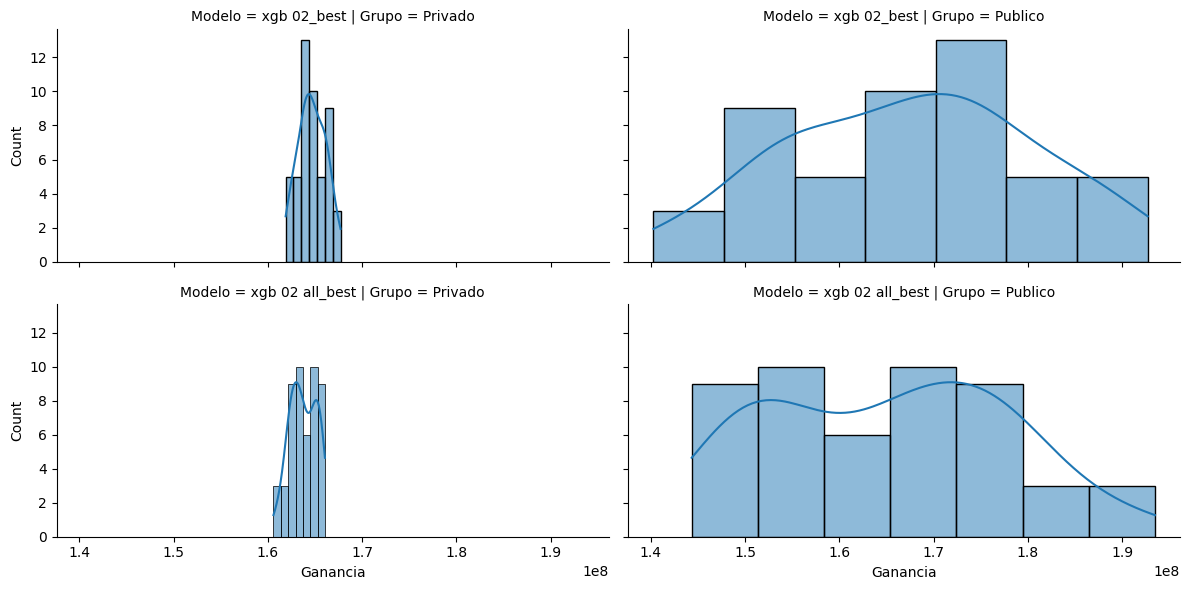

Ganancia media del modelo xgb 02 privado: 164688066.6666667
Ganancia media del modelo xgb 02 publico: 167497400.0
Ganancia media del modelo xgb 02 all privado: 163742288.88888887
Ganancia media del modelo xgb 02 all publico: 165159400.0

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1691.5
P-valor = 0.998844785187616
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgb 02 all_priv es mayor que la de xgb 02_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1387.0
P-valor = 0.828416392820238
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgb 02 all_pub es mayor que la de xgb 02_pub.


In [41]:
model_a = "xgb 02"
model_b = "xgb 02 all"

plot_comparisons_on_kaggle_split(model_a, df_bt.pri_best_xgb_02.values, df_bt.pub_best_xgb_02.values,
                                model_b, df_bt.pri_best_xgb_02_all.values, df_bt.pub_best_xgb_02_all.values)

___